In [23]:
import os
import qiskit
from qiskit import transpile
import torch
from qiskit_aer import AerSimulator
from qiskit import transpile, QuantumCircuit as QiskitQuantumCircuit
from sklearn.metrics import accuracy_score
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Function
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torchxrayvision as xrv
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.models import ResNet50_Weights
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
from torchvision.io import read_image
from sklearn.metrics import f1_score, precision_score, recall_score
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os, random, json, cv2, math
from PIL import Image
from tqdm import tqdm

In [24]:
QC_outputs = ['000', '001', '010', '011', '100', '101', '110', '111']

In [25]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms

class MammoDataset(Dataset):
    def __init__(self, root_dir, train=True, data_augmentation=False):
        self.image_paths = []
        self.labels = []
        
        # Define the base transform
        base_transform = [transforms.Resize((250, 250)),
                          transforms.ToTensor(),
                          transforms.Normalize(mean=[0.3577, 0.3577, 0.3577], std=[0.2662, 0.2662, 0.2662])]
        
        # Add data augmentation if specified
        if train and data_augmentation:
            augmentation_transform = [transforms.RandomVerticalFlip(),
                                      transforms.GaussianBlur(kernel_size=(3, 3))]
            self.transform = transforms.Compose(augmentation_transform + base_transform)
        else:
            self.transform = transforms.Compose(base_transform)
        
        # Collect image paths and labels
        for label in ['0', '1']:
            folder_path = os.path.join(root_dir, label)
            self.image_paths.extend([os.path.join(folder_path, img_name) for img_name in os.listdir(folder_path)])
            self.labels.extend([int(label)] * len(os.listdir(folder_path)))

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return image, label

In [26]:
class Resnet(torch.nn.Module):
    def __init__(self, out_features = 2):
        super(Resnet, self).__init__()
        self.resnet = models.resnet18(weights=ResNet50_Weights.IMAGENET1K_V1)
        self.resnet.fc = torch.nn.Linear(self.resnet.fc.in_features, out_features)
    def forward(self, x):
        return self.resnet(x)

In [27]:
class QuantumCircuit:
    """ 
    This class provides a simple interface for interaction 
    with the quantum circuit 
    """
    
    def __init__(self, n_qubits, backend, shots):
        # --- Circuit definition ---
        self._circuit = qiskit.QuantumCircuit(n_qubits)
        
        all_qubits = [i for i in range(n_qubits)]
        self.theta_0 = qiskit.circuit.Parameter('theta0')
        
        self._circuit.h(all_qubits)
        self._circuit.barrier()
        self._circuit.ry(self.theta_0, all_qubits)
        #self._circuit.rx(self.theta, all_qubits)
        
        self._circuit.measure_all()
        # ---------------------------

        self.backend = backend
        self.shots = shots
    
    def run(self, thetas):
        param_values = {
            self.theta_0: thetas[0],
        }
        

        bound_circuit = self._circuit.assign_parameters(param_values)

        transpiled_circuit = transpile(bound_circuit, self.backend)

        job = self.backend.run(transpiled_circuit, shots=self.shots)
        
        result = job.result().get_counts()
        
        expectations = []
        if type(result)==list:
            for i in result:
                counts = np.array(list(i.values()))
                states = np.array(list(i.keys())).astype(float)
            
                # Compute probabilities for each state
                probabilities = counts / self.shots
                # Get state expectation
                expectation = np.sum(states * probabilities)

                expectations.append(expectation)
        else:
            counts = np.array(list(result.values()))
            states = np.array(list(result.keys())).astype(float)
        
            # Compute probabilities for each state
            probabilities = counts / self.shots
            # Get state expectation
            expectation = np.sum(states * probabilities)

            expectations.append(expectation)
        return np.array(expectations)

In [28]:
class HybridFunction(torch.autograd.Function):
    """ Hybrid quantum - classical function definition """
    
    @staticmethod
    def forward(ctx, input, quantum_circuit, shift):
        """ Forward pass computation """
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit
        expectation_z = ctx.quantum_circuit.run(input.tolist()[0])
        result = torch.tensor([expectation_z])
        
        ctx.save_for_backward(input, result)

        return result
        
    @staticmethod
    def backward(ctx, grad_output):
        """ Backward pass computation """
        input, expectation_z = ctx.saved_tensors
        input_list = np.array(input.tolist()[0])
        
        shift_right = input_list + np.ones(input_list.shape) * ctx.shift
        shift_left = input_list - np.ones(input_list.shape) * ctx.shift
        gradients = []
        for i in range(len(input_list)):
            expectation_right = ctx.quantum_circuit.run([shift_right[i]])
            expectation_left  = ctx.quantum_circuit.run([shift_left[i]])
            gradient = expectation_right - expectation_left
            gradients.append(gradient)
        
        gradients = np.array([gradients]).T
        return torch.tensor([gradients]).float() * grad_output.float(), None, None



class Hybrid(nn.Module):
    """ Hybrid quantum - classical layer definition """
    
    def __init__(self, n_qubits, backend, shots, shift):
        super(Hybrid, self).__init__()
        self.quantum_circuit = QuantumCircuit(n_qubits, backend, shots)
        self.shift = shift
        
    def forward(self, input):
        batch_results = []
        for i in range(input.shape[0]):
            result = HybridFunction.apply(input[i].unsqueeze(0), self.quantum_circuit, self.shift)
            batch_results.append(result)
        return torch.cat(batch_results)

In [29]:
class qcNet(nn.Module):
    def __init__(self):
        super(qcNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5, stride=2, padding=1)
        self.conv2 = nn.Conv2d(6, 15, kernel_size=3, stride=2, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=1)
        self.drop1 = nn.Dropout2d(p=0.2)
        self.drop2 = nn.Dropout2d(p=0.5)
        self.fc1 = nn.Linear(55815, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)
        sim = AerSimulator(device="cuda")
        self.hybrid = Hybrid(self.fc3.out_features, sim, 1000, np.pi / 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = self.drop1(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.drop1(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.drop2(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.hybrid(x)
        x = torch.cat((x, 1 - x), -1)
        return x

In [30]:
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         # Load pre-trained ResNet50 model
#         self.resnet = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
#         # Modify the fully connected layer to match the required output features
#         self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 84)
        
#         self.drop1 = nn.Dropout2d(p=0.2)
#         self.drop2 = nn.Dropout2d(p=0.5)
#         self.fc1 = nn.Linear(84, 1)
#         sim = AerSimulator()
#         self.hybrid = Hybrid(self.fc1.out_features, sim, 1000, np.pi / 2)

#     def forward(self, x):
#         x = self.resnet(x)
#         x = self.drop1(x)
#         x = F.relu(self.fc1(x))
#         x = self.hybrid(x)
#         x = torch.cat((x, 1 - x), -1)
#         return x

In [31]:
train_dir = 'C:\\Users\\Win10\\PycharmProjects\\QuantumResearch\\INbreast\\data\\png\\train'
test_dir = 'C:\\Users\\Win10\\PycharmProjects\\QuantumResearch\\INBreast\\data\\png\\test'

# Instancia os datasets

train_dataset = MammoDataset(root_dir=train_dir, data_augmentation=True)
test_dataset = MammoDataset(root_dir=test_dir, train=False)

# Cria os DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [32]:
model = qcNet().cpu()
loss_func = nn.NLLLoss().cpu()
optimizer = optim.Adam(model.parameters(), lr=0.01)
epochs = 10
loss_list = []
thetas = []

In [33]:
model.train()
for epoch in range(epochs):
    total_loss = []
    
    for batch_idx, (image, label) in enumerate(train_loader):
        label = label.unsqueeze(1)
        
        # Converta os tensores para o tipo correto
        image = image.cpu()
        label = label.cpu()

        optimizer.zero_grad()  # Zere os gradientes

        # Passe as imagens pelo modelo
        prediction = model(image)

        prediction = prediction.cpu()

        #Get prediction label from the index with the maximum score
        #prediction_label = torch.argmax(prediction, dim=1)
        print(prediction)

        #prediction_label = prediction_label.unsqueeze(1)
        # Calcule a perda
        
        loss = loss_func(prediction, label.squeeze().long())

        # Propagação para trás e atualização dos pesos
        loss.backward()
        optimizer.step()

        # Armazene as informações
        total_loss.append(loss.item())
        print(f"  Batch {batch_idx + 1} concluído com loss: {loss.item():.4f}")
        
    avg_loss = np.mean(total_loss)
    loss_list.append(avg_loss)

    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss}")

    model_save_path = f"model_epoch_{epoch}.pth"
    torch.save(model.state_dict(), model_save_path)

tensor([[0.4610, 0.5390],
        [0.4520, 0.5480],
        [0.4860, 0.5140],
        [0.4700, 0.5300],
        [0.4540, 0.5460],
        [0.4560, 0.5440],
        [0.4870, 0.5130],
        [0.4450, 0.5550],
        [0.4730, 0.5270],
        [0.4850, 0.5150],
        [0.5020, 0.4980],
        [0.4470, 0.5530],
        [0.4560, 0.5440],
        [0.4620, 0.5380],
        [0.4560, 0.5440],
        [0.4680, 0.5320],
        [0.4630, 0.5370],
        [0.4790, 0.5210],
        [0.4420, 0.5580],
        [0.4560, 0.5440],
        [0.4700, 0.5300],
        [0.4770, 0.5230],
        [0.4580, 0.5420],
        [0.4910, 0.5090],
        [0.4110, 0.5890],
        [0.5060, 0.4940],
        [0.4920, 0.5080],
        [0.4490, 0.5510],
        [0.4810, 0.5190],
        [0.4710, 0.5290],
        [0.4750, 0.5250],
        [0.4690, 0.5310]], dtype=torch.float64, grad_fn=<CatBackward0>)
  Batch 1 concluído com loss: -0.4812
tensor([[0.8020, 0.1980],
        [0.7650, 0.2350],
        [0.9020, 0.0980],
      

In [34]:
model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for batch_idx, (image, label) in enumerate(test_loader):
        label = label.unsqueeze(1)
        
        # Converta os tensores para o tipo correto
        image = image.cpu()
        label = label.cpu()
        # image, label = image.type(dtype=torch.cuda.FloatTensor), label.type(dtype=torch.cuda.LongTensor)
        try:
            prediction = model(image)
            predicted_class = prediction.argmax(dim=1)
            all_labels.extend(label.cpu().numpy())
            all_predictions.extend(predicted_class.cpu().numpy())
        except:
            continue

# Calculate precision, recall, and F1 score
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Calcular acurácia
accuracy = accuracy_score(all_labels, all_predictions)
print(f"Acurácia: {accuracy:.4f}")

Precision: 0.3409
Recall: 0.6000
F1 Score: 0.4348
Acurácia: 0.5244


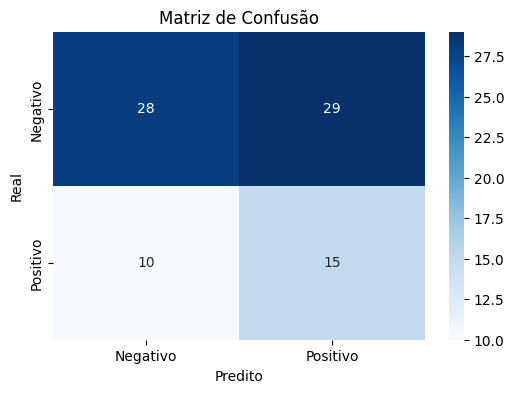

In [35]:
# Gerar matriz de confusão
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Plotar matriz de confusão
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negativo', 'Positivo'],
            yticklabels=['Negativo', 'Positivo'])
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()